# Titanic

In [1]:
import numpy as np
import pandas as pd
import os
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

## Exproratoly Data Analysis 

In [2]:
train_id = train.PassengerId
test_id = test.PassengerId
print(train.info())
print("*"*40)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

データセットに関して以下の事がわかる:  
・全サンプル数はtrain891, test４１８  
・11の変数と, １つの予測変数を持つ  
・trainではAge, Cabin, Embarkedで欠損値  
・testではAge, Fare, Cabinで欠損値

In [3]:
train.Survived.mean()

0.3838383838383838

trainデータでの生存率は約38%ほど, これを基準に考える. 

In [4]:
# カラムごとの欠損値の割合を算出
def miss_parcent(df):
    total = df.isna().sum().sort_values(ascending = False)
    percent = round(total / len(df) * 100, 2)
    return pd.concat([total, percent], axis = 1, keys=["Total", "Percent"])

In [5]:
print(miss_parcent(train))
print(miss_parcent(test))

             Total  Percent
Cabin          687    77.10
Age            177    19.87
Embarked         2     0.22
Fare             0     0.00
Ticket           0     0.00
Parch            0     0.00
SibSp            0     0.00
Sex              0     0.00
Name             0     0.00
Pclass           0     0.00
Survived         0     0.00
PassengerId      0     0.00
             Total  Percent
Cabin          327    78.23
Age             86    20.57
Fare             1     0.24
Embarked         0     0.00
Ticket           0     0.00
Parch            0     0.00
SibSp            0     0.00
Sex              0     0.00
Name             0     0.00
Pclass           0     0.00
PassengerId      0     0.00


Cabinはtrain, test共に7割り近くが欠損している.  
Ageはtrain, test共に2割り近くが欠損している.  
Embarked, Fareは少しの欠損のみなので, Age, Cabinをどう埋めるかが問題. 

### Embarked

In [6]:
# カテゴリ変数のカラムに対して, 変数ごとの分布を返す. 
def cat_percent(df_tr, df_te, column):
    total_tr = df_tr[column].value_counts(dropna = False).sort_values(ascending = False)
    total_te = df_te[column].value_counts(dropna = False).sort_values(ascending = False)
    par_tr = round(total_tr / len(df_tr) * 100, 2)
    par_te = round(total_te / len(df_te) * 100, 2)
    res_tr = pd.concat([total_tr, par_tr], axis = 1, keys = ["Total_tr", "Percent_tr"])
    res_te = pd.concat([total_te, par_te], axis = 1, keys = ["Total_te", "Percent_te"])
    return pd.merge(res_tr, res_te, left_index = True, right_index = True, how = "outer")

In [7]:
print(cat_percent(train, test, "Embarked"))

     Total_tr  Percent_tr  Total_te  Percent_te
NaN         2        0.22       NaN         NaN
C         168       18.86     102.0       24.40
Q          77        8.64      46.0       11.00
S         644       72.28     270.0       64.59


クラス間の分布はtrain, testで大体同じ.

In [8]:
train[train.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Embarkedを欠損した二つのデータは, Sex, Pclass, Fare, Ticket, Cabinが共通している. 

In [9]:
print(train[train.Cabin == "B28"])
print(train[train.Ticket == "113572"])

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  
     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


Cabin, Ticketが共通の乗客は他にはいない. 
そのため, Sex = female, Pclass = 1のFareの平均を調べる. 

In [10]:
train.groupby(["Embarked", "Pclass"]).mean()

PassengerId  Survived        Age     SibSp     Parch  \
Embarked Pclass                                                         
C        1        440.800000  0.694118  38.027027  0.376471  0.317647   
         2        444.352941  0.529412  22.766667  0.588235  0.529412   
         3        451.484848  0.378788  20.741951  0.348485  0.378788   
Q        1        329.500000  0.500000  38.500000  1.500000  0.000000   
         2        418.000000  0.666667  43.500000  0.000000  0.000000   
         3        420.347222  0.375000  25.937500  0.416667  0.180556   
S        1        477.842520  0.582677  38.152037  0.433071  0.393701   
         2        446.634146  0.463415  30.386731  0.390244  0.371951   
         3        440.685552  0.189802  25.696552  0.705382  0.439093   

                       Fare  
Embarked Pclass              
C        1       104.718529  
         2        25.358335  
         3        11.214083  
Q        1        90.000000  
         2        12.350000  
         3        11.183393  
S        1        70.364862  
         2        20.327439  
         3        14.644083

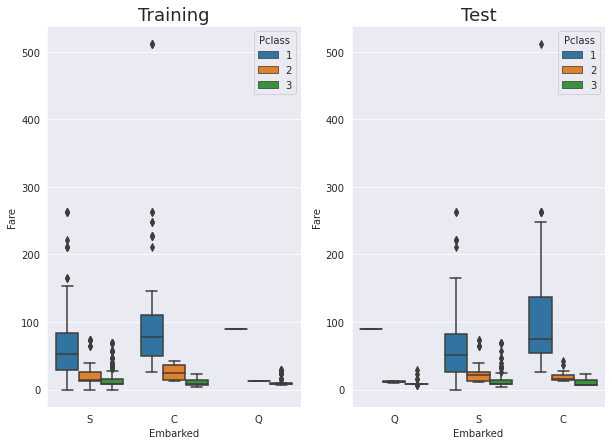

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize = (10, 7), ncols = 2)
ax1 = sns.boxplot(x = "Embarked", y = "Fare", hue = "Pclass", data = train, ax = ax[0])
ax2 = sns.boxplot(x = "Embarked", y = "Fare", hue = "Pclass", data = test, ax = ax[1])
ax1.set_title("Training", fontsize = 18)
ax2.set_title("Test", fontsize = 18)
fig.show()

したがって, Embarkedの欠損値はCで埋める. 

### SibSp, Parch

<Figure size 720x360 with 0 Axes>

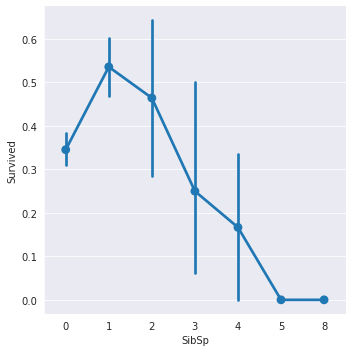

In [12]:
fig = plt.figure(figsize=(10, 5))
sns.catplot(x = "SibSp", y = "Survived", data = train, kind = "point")
fig.show()

<Figure size 720x360 with 0 Axes>

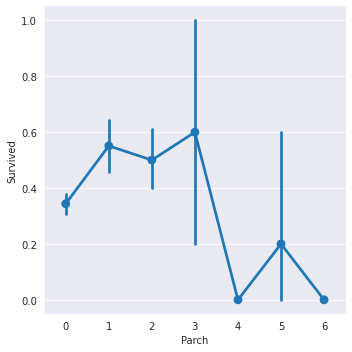

In [13]:
fig = plt.figure(figsize=(10, 5))
sns.catplot(x = "Parch", y = "Survived", data = train, kind = "point")
fig.show()

SibSp, Parch共に0の場合は生存率が低下するが, 大きい場合も低下する.  
両方を合わせると, 家族の数になるので, それを用いる.  

<Figure size 720x360 with 0 Axes>

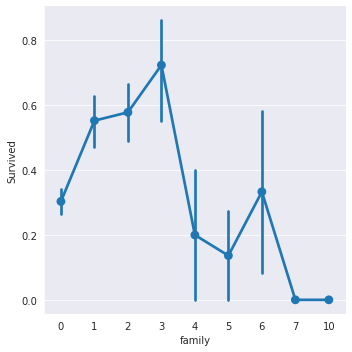

In [14]:
_train = train.copy()
_train["family"] = _train["SibSp"] + _train["Parch"]
fig = plt.figure(figsize=(10, 5))
sns.catplot(x = "family", y = "Survived", data = _train, kind = "point")
fig.show()

### Pclass

In [15]:
cat_percent(train, test, "Pclass")

,Total_tr,Percent_tr,Total_te,Percent_te
3,491,55.11,218,52.15
1,216,24.24,107,25.60
2,184,20.65,93,22.25


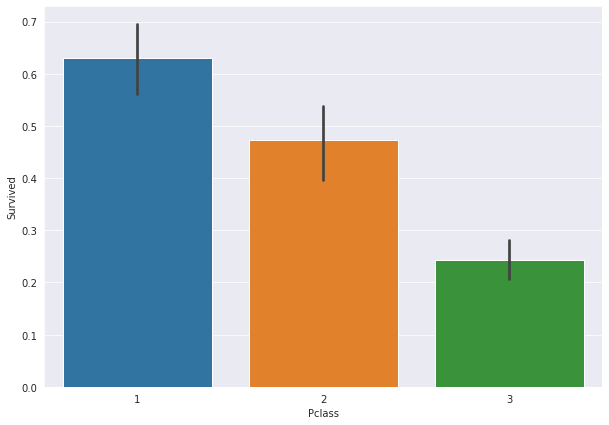

In [16]:
plt.subplots(figsize = (10, 7))
sns.barplot(x = "Pclass", y = "Survived", data = train)
plt.show()

クラス間に生存率の違いが見られるため, 有用な特徴であると考えられる. 

### Sex

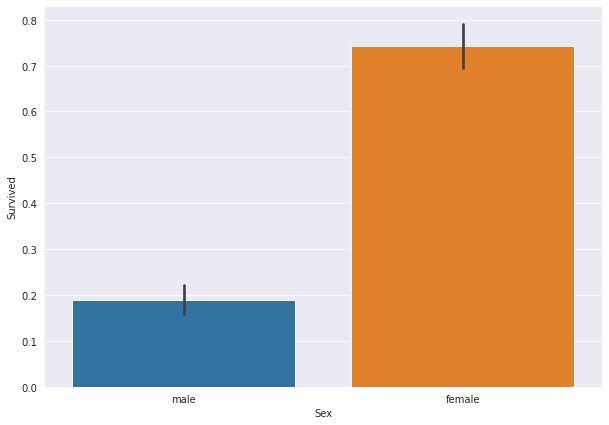

In [17]:
plt.subplots(figsize = (10, 7))
sns.barplot(x = "Sex", y = "Survived", data = train)
plt.show()

### Ticket

In [18]:
_train = train.copy()
_train["length"] = [len(i) for i in _train.Ticket]
_train.length.unique()

array([ 9,  8, 16,  6,  5,  7,  4, 10, 13, 15, 12, 11, 17, 18,  3])

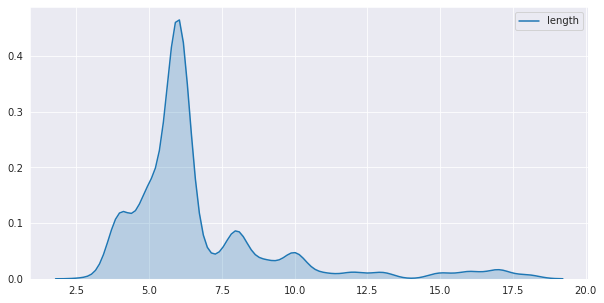

In [19]:
fig = plt.figure(figsize=(10, 5))
sns.kdeplot(_train.length, shade = True)
fig.show()

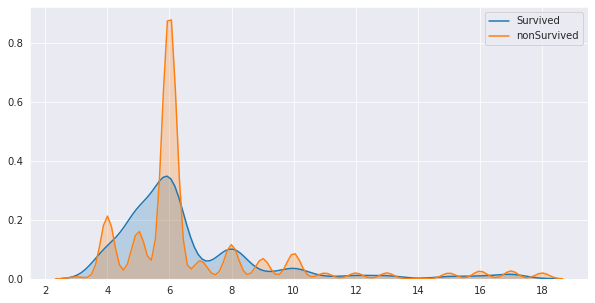

In [20]:
fig = plt.figure(figsize=(10, 5))
sns.kdeplot(_train[_train.Survived == 1].length, shade = True, label = "Survived")
sns.kdeplot(_train[_train.Survived == 0].length, shade = True, label = "nonSurvived")
fig.show()

異なる分布を持つため, Ticketの文字の長さは使えそう

### Name

In [21]:
def __create_title(df):
    tmp = [i.split('.')[0] for i in df.Name]
    df["title"] = [i.split(',')[1] for i in tmp]
    for i in df.title.unique():
        df.replace(i, i[1:], inplace = True)
    return df

In [22]:
_train = train.copy()
_test = test.copy()
_train = __create_title(_train)
_test = __create_title(_test)
cat_percent(_train, _test, "title")

,Total_tr,Percent_tr,Total_te,Percent_te
Capt,1.0,0.11,NaN,NaN
Col,2.0,0.22,2.0,0.48
Don,1.0,0.11,NaN,NaN
Dona,NaN,NaN,1.0,0.24
Dr,7.0,0.79,1.0,0.24
Jonkheer,1.0,0.11,NaN,NaN
Lady,1.0,0.11,NaN,NaN
Major,2.0,0.22,NaN,NaN
Master,40.0,4.49,21.0,5.02
Miss,182.0,20.43,78.0,18.66


敬称は身分も示すので, testデータに出現しない敬称のデータを利用すると不要なノイズを与えてしまう.  
また, 両方に出現するものでも, Rareなものはまとめてカテゴライズする.  
また, "Ms"と"Mrs"は合体させる.  
削除: ("Capt", "Don", "Jonkheer", "Lady", "Major", "Mlle", "Mme", "Sir", "the Countess")  
Rare: ("Col", "Dona", "Dr", "Rev")

### Age

In [23]:
print(_train[_train.Age.isna()].title.unique())
print(_test[_test.Age.isna()].title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Dr']
['Mr' 'Mrs' 'Miss' 'Ms' 'Master']


titleのうち, 削除する変数を含んでいないため, titleごとの平均値で欠損値を埋める. 

### Cabin

In [24]:
_train.Cabin.fillna("N", inplace = True)
_test.Cabin.fillna("N", inplace = True)
_train.Cabin = [i[0] for i in _train.Cabin]
_test.Cabin = [i[0] for i in _test.Cabin]

In [25]:
cat_percent(_train, _test, "Cabin")

,Total_tr,Percent_tr,Total_te,Percent_te
A,15,1.68,7.0,1.67
B,47,5.27,18.0,4.31
C,59,6.62,35.0,8.37
D,33,3.70,13.0,3.11
E,32,3.59,9.0,2.15
F,13,1.46,8.0,1.91
G,4,0.45,1.0,0.24
N,687,77.10,327.0,78.23
T,1,0.11,NaN,NaN


Tはtrainにしか無いので, 消去する. 

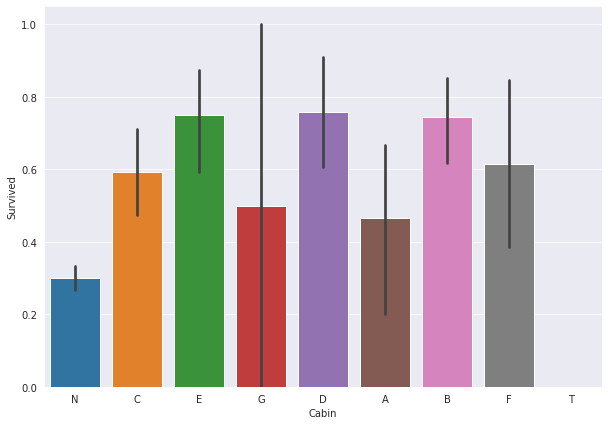

In [26]:
plt.subplots(figsize = (10, 7))
sns.barplot(x = "Cabin", y = "Survived", data = _train)
plt.show()

### Fare

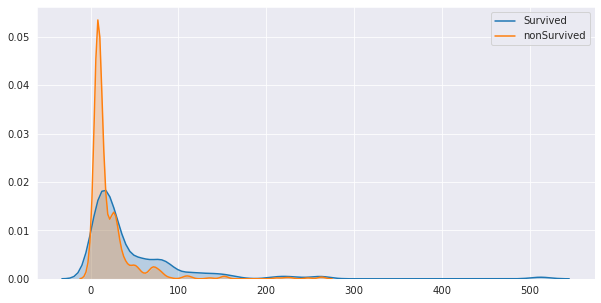

In [27]:
fig = plt.figure(figsize=(10, 5))
sns.kdeplot(_train[_train.Survived == 1].Fare, shade = True, label = "Survived")
sns.kdeplot(_train[_train.Survived == 0].Fare, shade = True, label = "nonSurvived")
fig.show()

testのFareは分布から, 中央値で埋める

## Feature Engineering & Cleaning Dataset

### Feature Create 

In [28]:
def create_family(df):
    df["family"] = df.SibSp + df.Parch + 1
    return df

In [29]:
def create_title(df):
    tmp = [i.split('.')[0] for i in df.Name]
    df["title"] = [i.split(',')[1] for i in tmp]
    for i in df.title.unique():
        df.replace(i, i[1:], inplace = True)
    del_list = ["Capt", "Don", "Jonkheer", "Lady", "Major", "Mlle", "Mme", "Sir", "the Countess"]
    df = df[~df.title.isin(del_list)].copy()
    rare_list = ["Col", "Dona", "Dr", "Rev"]
    df.replace(rare_list, "Rare", inplace = True)
    df.replace("Ms", "Mrs", inplace = True)
    return df

In [30]:
def create_length(df):
    df["length"] = [len(i) for i in df.Ticket]
    return df

In [31]:
def create_PerFare(df):
    df["PerFare"] = df.Fare / df.family
    return df

In [32]:
def create_Freq_Ticket(df):
    df["Ini_Ticket"] = [i[0] for i in df.Ticket]
    df["Freq_Ticket"] = df.groupby("Ini_Ticket")["PassengerId"].transform("count")
    df["Ticket_Fare"] = df.groupby("Ini_Ticket")["Fare"].transform("mean")
    return df

In [33]:
def create_Cabin_etc(df):
    df["Freq_Cabin"] = df.groupby("Cabin")["PassengerId"].transform("count")
    df["Cabin_Fare"] = df.groupby("Cabin")["Fare"].transform("mean")
    return df

In [34]:
def create_title_etc(df):
    df["title_age"] = df.groupby("title")["Age"].transform("mean")
    df["title_Fare"] = df.groupby("title")["Fare"].transform("median")
    return df

In [35]:
def create_miss_Cabin(df):
    df["miss_Cabin"] = [1 if i == "N" else 0 for i in df.Cabin]
    return df

In [36]:
def create_is_alone(df):
    df["is_alone"] = [i if i == 1 else 0 for i in df.family]
    return df

### Cleaning Dataset

In [37]:
def clean_Fare(df):
    df.Fare.fillna(df.Fare.median(), inplace = True)
    return df

In [38]:
def clean_Age(df):
    df.Age.fillna(df.Age.median(), inplace = True)
    return df

In [39]:
def clean_Cabin(df):
    df.Cabin.fillna("N", inplace = True)
    df.Cabin = [i[0] for i in df.Cabin]
    df = df[df.Cabin != "T"]
    return df

In [40]:
def clean_Embarked(df):
    df.Embarked.fillna("S", inplace = True)
    return df

In [41]:
def pre_process(df):
    df = create_family(df)
    df = create_Freq_Ticket(df)
    df = create_title(df)
    df = create_length(df)
    df = clean_Fare(df)
    df = clean_Age(df)
    df = clean_Cabin(df)
    df = clean_Embarked(df)
    df = create_PerFare(df)
    df = create_miss_Cabin(df)
    df = create_Cabin_etc(df)
    df = create_title_etc(df)
    df = create_is_alone(df)
    return df

In [42]:
_train = pre_process(train)
_test = pre_process(test)
_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_Fare,title,length,PerFare,miss_Cabin,Freq_Cabin,Cabin_Fare,title_age,title_Fare,is_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,9.975286,Mr,9,3.62500,1,685,19.172791,31.336240,9.28750,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,114.085831,Mrs,8,35.64165,0,57,102.261840,34.769841,26.00000,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,17.347822,Miss,16,7.92500,1,685,19.172791,23.005495,15.62085,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,62.126797,Mrs,6,26.55000,0,57,102.261840,34.769841,26.00000,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,15.969611,Mr,6,8.05000,1,685,19.172791,31.336240,9.28750,1


In [43]:
_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'family', 'Ini_Ticket',
       'Freq_Ticket', 'Ticket_Fare', 'title', 'length', 'PerFare',
       'miss_Cabin', 'Freq_Cabin', 'Cabin_Fare', 'title_age', 'title_Fare',
       'is_alone'],
      dtype='object')

全ての欠損値を埋める事ができた.  

## Training Model

In [44]:
use_train = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'family', 
             'Ticket_Fare', 'length', 'PerFare','title_age', 'title_Fare','is_alone']
use_test = ['Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'family', 
             'Ticket_Fare', 'length', 'PerFare','title_age', 'title_Fare','is_alone']
cate = ["Sex"]

_train = _train[use_train]
_test = _test[use_test]
for i in cate:
    _train[i] = _train[i].astype('category')
    _test[i] = _test[i].astype('category')
    _train[i] = _train[i].cat.codes
    _test[i] = _test[i].cat.codes

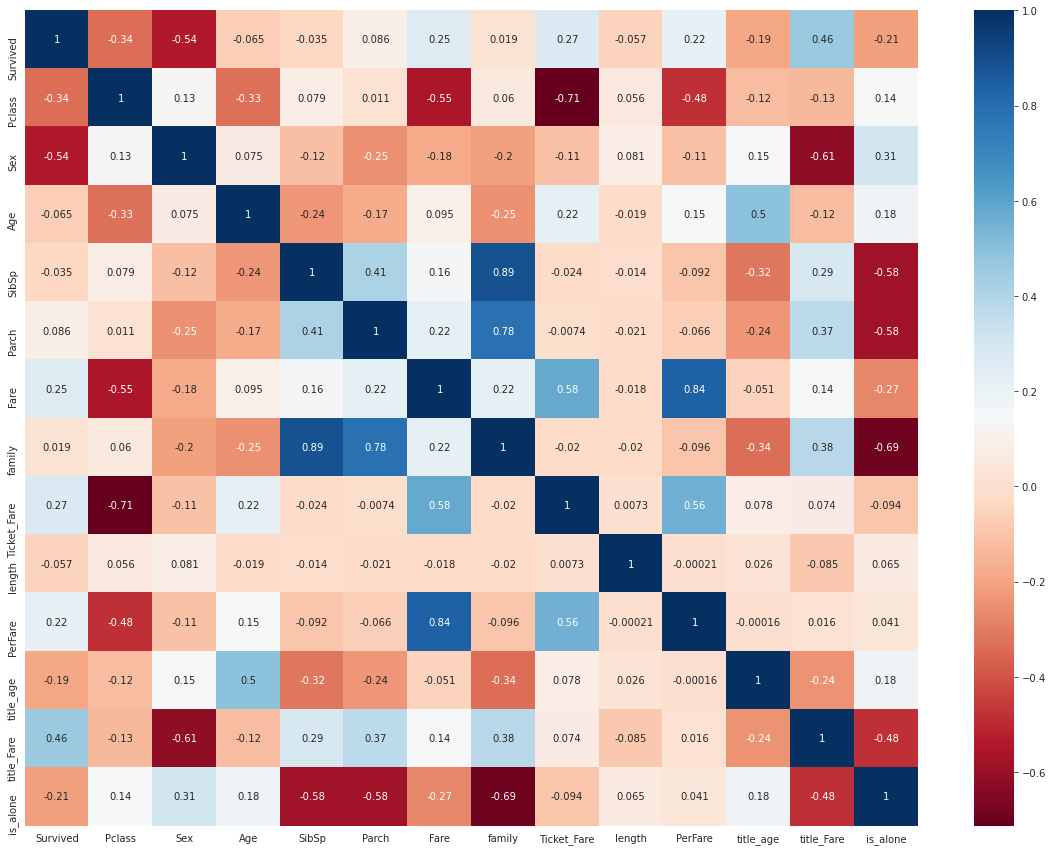

In [45]:
sns.set_style("whitegrid")
plt.subplots(figsize = (20, 15))
sns.heatmap(_train.corr(), annot = True, cmap = "RdBu", fmt = ".2g")

In [46]:
y = _train.Survived
X = _train.drop("Survived", axis = 1)

In [47]:
!pip -q install BorutaShap;

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


100%|██████████| 40/40 [02:25<00:00,  3.64s/it]


9 attributes confirmed important: ['Pclass', 'Sex', 'family', 'Fare', 'title_age', 'Age', 'Ticket_Fare', 'title_Fare', 'PerFare']
4 attributes confirmed unimportant: ['Parch', 'is_alone', 'length', 'SibSp']
0 tentative attributes remains: []


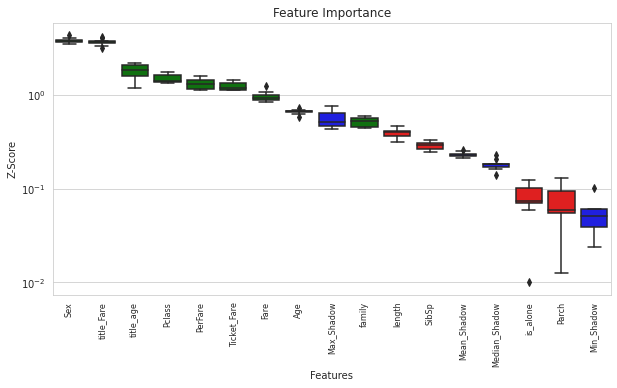

In [48]:
from BorutaShap import BorutaShap
Feature_Selecter = BorutaShap(importance_measure = "shap", classification = True)
Feature_Selecter.fit(X = X, y = y, n_trials = 40, random_state = 0)
Feature_Selecter.plot(which_features = 'all', figsize=(10, 5))
_X = Feature_Selecter.Subset()

In [49]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
skf = StratifiedKFold(n_splits = 10)
def opt_xgb(trial):
    cv_params = {
        "early_stopping_rounds": 20,
        "num_boost_round": 600,
        "nfold":5, 
        "stratified":True, 
        "seed":42, 
        "verbose_eval":False   
    }
    params = {
        "objective": "binary:logistic",
        "tree_method": "approx",
        "eval_metric": "logloss",
        "random_state": 0,
        "learning_rate": 0.1,
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_discrete_uniform("min_child_weight", 0.1, 1.0, 0.05),
        "gamma": trial.suggest_loguniform("gamma", 0.01, 1.0),
        "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.1),
        "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.7, 1.0, 0.1)
    }
    dtrain = xgb.DMatrix(X_cros, y_cros)
    scores = xgb.cv(params = params, dtrain = dtrain, **cv_params)
    trial.set_user_attr('n_estimators', len(scores))
    res = np.mean(scores['test-logloss-mean'])
    return res

def opt_2(trial):
    params = {
        "objective": "binary:logistic",
        "tree_method": "approx",
        "eval_metric": "logloss",
        "random_state": 0,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.15),
        "n_estimators": trial.suggest_int("n_estimators", 10, 300, 10)
    }
    model = xgb.XGBClassifier(**params, **study.best_params)
    res = cross_val_score(model, X_cros, y_cros, scoring = "neg_log_loss", cv = skf)
    return res.mean()

In [50]:
def tune_parameter():
    opt = optuna.create_study()
    opt.optimize(opt_xgb, n_trials = 300, show_progress_bar = True)
    print(opt.best_params)
    print(opt.best_value)
    print(opt.best_trial)
    return opt
    
def tune_rate_iter():
    opt = optuna.create_study(direction = "maximize")
    opt.optimize(opt_2, n_trials = 200, show_progress_bar = True)
    print(opt.best_params)
    print(opt.best_value)
    print(opt.best_trial)
    return opt

In [51]:
X_cros = _X
y_cros = y
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = tune_parameter()
study2 = tune_rate_iter()


{'max_depth': 3, 'min_child_weight': 0.65, 'gamma': 0.061211967944965216, 'subsample': 0.7, 'colsample_bytree': 1.0}
0.4301300756756757
FrozenTrial(number=201, value=0.4301300756756757, datetime_start=datetime.datetime(2021, 1, 8, 9, 0, 48, 629047), datetime_complete=datetime.datetime(2021, 1, 8, 9, 0, 48, 920203), params={'max_depth': 3, 'min_child_weight': 0.65, 'gamma': 0.061211967944965216, 'subsample': 0.7, 'colsample_bytree': 1.0}, distributions={'max_depth': IntUniformDistribution(high=10, low=3, step=1), 'min_child_weight': DiscreteUniformDistribution(high=1.0, low=0.1, q=0.05), 'gamma': LogUniformDistribution(high=1.0, low=0.01), 'subsample': DiscreteUniformDistribution(high=1.0, low=0.6, q=0.1), 'colsample_bytree': DiscreteUniformDistribution(high=1.0, low=0.7, q=0.1)}, user_attrs={'n_estimators': 74}, system_attrs={}, intermediate_values={}, trial_id=201, state=TrialState.COMPLETE)



{'learning_rate': 0.017586099928300843, 'n_estimators': 240}
-0.401014056324262
FrozenTrial(number=179, value=-0.401014056324262, datetime_start=datetime.datetime(2021, 1, 8, 9, 4, 56, 40534), datetime_complete=datetime.datetime(2021, 1, 8, 9, 4, 57, 210909), params={'learning_rate': 0.017586099928300843, 'n_estimators': 240}, distributions={'learning_rate': LogUniformDistribution(high=0.15, low=0.01), 'n_estimators': IntUniformDistribution(high=300, low=10, step=10)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=179, state=TrialState.COMPLETE)


In [52]:
params = {
        "objective": "binary:logistic",
        "tree_method": "approx",
        "eval_metric": "auc",
        "random_state": 0}
model = xgb.XGBClassifier(**params, **study.best_params, **study2.best_params)
res = cross_val_score(model, _X, y, scoring = "accuracy", cv = skf)
model.fit(_X, y)
print(res.mean(), res.std())

0.8350574712643677 0.032949023687626144


## Adversarial Validation

In [53]:
import lightgbm as lgb
def adv_validation(data):
    X_adv = data.copy()
    X_adv["is_test"] = 0
    __test = _test[data.columns]
    __test["is_test"] = 1
    X_adv = pd.concat([X_adv, __test])
    X_adv_tr, X_adv_te = train_test_split(X_adv, test_size=0.33, random_state=42)
    y_adv_tr = X_adv_tr["is_test"]
    X_adv_tr = X_adv_tr.drop("is_test", axis = 1)
    y_adv_te = X_adv_te["is_test"]
    X_adv_te = X_adv_te.drop("is_test", axis = 1)
    model_adv = lgb.LGBMClassifier(
        n_estimators=300,
        random_state=42)
    model_adv.fit(
        X_adv_tr,
        y_adv_tr,
        eval_set=[(X_adv_tr, y_adv_tr), (X_adv_te, y_adv_te)],
        eval_names=['train', 'valid'],
        eval_metric='auc',
        verbose=50)
    sns.set_style("whitegrid")
    ax = lgb.plot_metric(model_adv.evals_result_, metric='auc')
    plt.show()
    return model_adv, X_adv_te

[50]	train's auc: 1	train's binary_logloss: 0.00432806	valid's auc: 1	valid's binary_logloss: 0.00399824
[100]	train's auc: 1	train's binary_logloss: 2.94627e-05	valid's auc: 1	valid's binary_logloss: 2.7053e-05
[150]	train's auc: 1	train's binary_logloss: 4.42946e-06	valid's auc: 1	valid's binary_logloss: 4.67243e-06
[200]	train's auc: 1	train's binary_logloss: 3.63489e-06	valid's auc: 1	valid's binary_logloss: 3.93869e-06
[250]	train's auc: 1	train's binary_logloss: 3.31483e-06	valid's auc: 1	valid's binary_logloss: 3.65036e-06
[300]	train's auc: 1	train's binary_logloss: 3.0438e-06	valid's auc: 1	valid's binary_logloss: 3.43315e-06


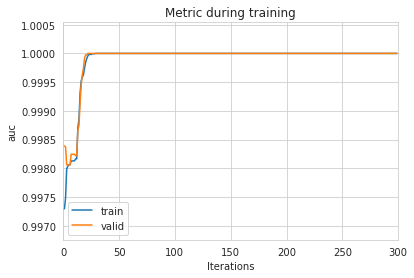

In [54]:
model_adv, X_adv_te = adv_validation(_X)

train, testデータをうまく区別できているため, train, testの分布は異なると考えられる. 

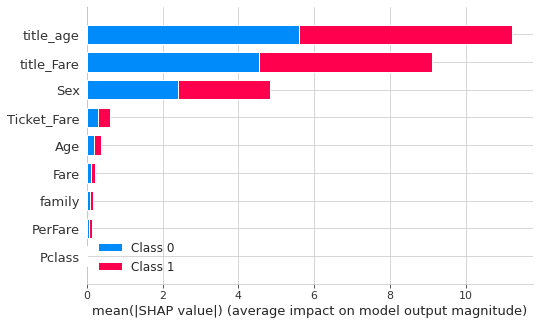

In [55]:
import shap
shap.initjs()
explainer = shap.explainers.Tree(model=model_adv)
shap_values = explainer.shap_values(X=X_adv_te)
shap.summary_plot(shap_values, X_adv_te, plot_type="bar")

title_age, title_Fare, Ticket_Fare, Ageを削除

[50]	train's auc: 0.775985	train's binary_logloss: 0.544051	valid's auc: 0.517916	valid's binary_logloss: 0.650281
[100]	train's auc: 0.801453	train's binary_logloss: 0.515038	valid's auc: 0.52195	valid's binary_logloss: 0.674213
[150]	train's auc: 0.819156	train's binary_logloss: 0.493889	valid's auc: 0.522434	valid's binary_logloss: 0.694235
[200]	train's auc: 0.832447	train's binary_logloss: 0.477943	valid's auc: 0.513647	valid's binary_logloss: 0.71349
[250]	train's auc: 0.840522	train's binary_logloss: 0.464991	valid's auc: 0.508748	valid's binary_logloss: 0.73483
[300]	train's auc: 0.846009	train's binary_logloss: 0.454882	valid's auc: 0.506208	valid's binary_logloss: 0.754487


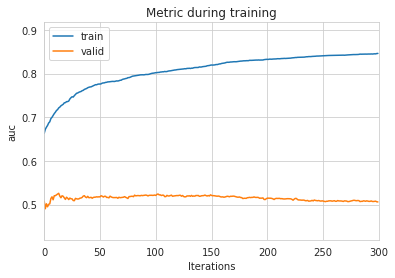

In [56]:
__X = _X[["Sex","Fare", "family", "PerFare", "Pclass"]]
model_adv, X_adv_te = adv_validation(__X)

AUCが0.5付近で, test, trainのデータがほぼ同質である. 

In [57]:
X_cros = __X
study = tune_parameter()
study2 = tune_rate_iter()


{'max_depth': 3, 'min_child_weight': 0.15000000000000002, 'gamma': 0.13196371183865474, 'subsample': 0.7, 'colsample_bytree': 1.0}
0.46331152413793103
FrozenTrial(number=292, value=0.46331152413793103, datetime_start=datetime.datetime(2021, 1, 8, 9, 6, 28, 601076), datetime_complete=datetime.datetime(2021, 1, 8, 9, 6, 28, 815341), params={'max_depth': 3, 'min_child_weight': 0.15000000000000002, 'gamma': 0.13196371183865474, 'subsample': 0.7, 'colsample_bytree': 1.0}, distributions={'max_depth': IntUniformDistribution(high=10, low=3, step=1), 'min_child_weight': DiscreteUniformDistribution(high=1.0, low=0.1, q=0.05), 'gamma': LogUniformDistribution(high=1.0, low=0.01), 'subsample': DiscreteUniformDistribution(high=1.0, low=0.6, q=0.1), 'colsample_bytree': DiscreteUniformDistribution(high=1.0, low=0.7, q=0.1)}, user_attrs={'n_estimators': 58}, system_attrs={}, intermediate_values={}, trial_id=292, state=TrialState.COMPLETE)



{'learning_rate': 0.04934487894503184, 'n_estimators': 250}
-0.42759395928604793
FrozenTrial(number=162, value=-0.42759395928604793, datetime_start=datetime.datetime(2021, 1, 8, 9, 9, 1, 579490), datetime_complete=datetime.datetime(2021, 1, 8, 9, 9, 2, 562547), params={'learning_rate': 0.04934487894503184, 'n_estimators': 250}, distributions={'learning_rate': LogUniformDistribution(high=0.15, low=0.01), 'n_estimators': IntUniformDistribution(high=300, low=10, step=10)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=162, state=TrialState.COMPLETE)


In [58]:
params = {
        "objective": "binary:logistic",
        "tree_method": "approx",
        "eval_metric": "auc",
        "random_state": 0}
model = xgb.XGBClassifier(**params, **study.best_params, **study2.best_params)
res = cross_val_score(model, __X, y, scoring = "accuracy", cv = skf)
model.fit(__X, y)
print(res.mean(), res.std())

0.8168103448275861 0.041243070489424084


## Submission

In [59]:
__test = _test[__X.columns]
y_pred = model.predict(__test)
Submit = pd.DataFrame()
Submit["PassengerId"] = test_id
Submit["Survived"] = y_pred
Submit.to_csv("titanic_output", index = False)